# Sentinel Fraud Detection - EDA Notebook

---

## 🎯 Project Objective

Sentinel National Bank is experiencing a rise in unauthorized transactions.

**Goal**: Detect fraudulent transactions using advanced data analysis.

**In this EDA, we aim to**:
- Explore the dataset  
- Uncover fraud patterns  
- Engineer features to support an accurate fraud detection model  

In [27]:

# ## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   step                1000 non-null   int64  
 1   type                1000 non-null   object 
 2   amount              1000 non-null   float64
 3   nameOrig            1000 non-null   object 
 4   oldbalanceOrg       1000 non-null   float64
 5   newbalanceOrig      1000 non-null   float64
 6   nameDest            1000 non-null   object 
 7   oldbalanceDest      1000 non-null   float64
 8   newbalanceDest      1000 non-null   float64
 9   isFraud             1000 non-null   int64  
 10  balance_shift_diff  1000 non-null   float64
 11  balanced            1000 non-null   bool   
dtypes: bool(1), float64(6), int64(2), object(3)
memory usage: 87.0+ KB

Summary Statistics:
              step        amount  oldbalanceOrg  newbalanceOrig  \
count  1000.000000  1.000000e+03 

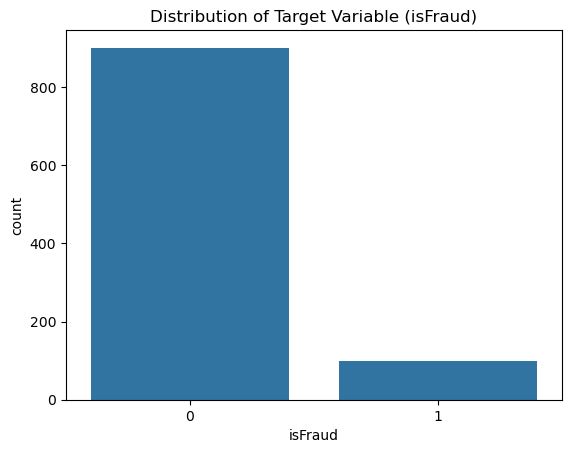

In [2]:
# ## 2. Load Cleaned Data
# Purpose: Load the cleaned dataset prepared during data wrangling
# Why: This dataset will be used to explore patterns related to fraudulent vs non-fraudulent transactions

df = pd.read_csv("../data/sentinel_cleaned_sample_1000.csv")

# ### Initial Inspection
print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nFraud Distribution (%):")
print(df['isFraud'].value_counts(normalize=True) * 100)

# Observation:
# - The dataset contains 1000 transactions, with no missing values.
# - Approximately 10% of transactions are labeled as fraudulent — this is a balanced dataset suitable for modeling.
# - Summary statistics show wide variation in transaction amounts and balances.

# ### Missing Values + Duplicates
print("\nMissing Values:")
print(df.isnull().sum())

num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

sns.countplot(x='isFraud', data=df)
plt.title("Distribution of Target Variable (isFraud)")
plt.show()

# Observation:
# - No missing values and no duplicate rows detected.
# - Class distribution is balanced (~10% fraud) — this reduces the risk of model bias toward non-fraud.


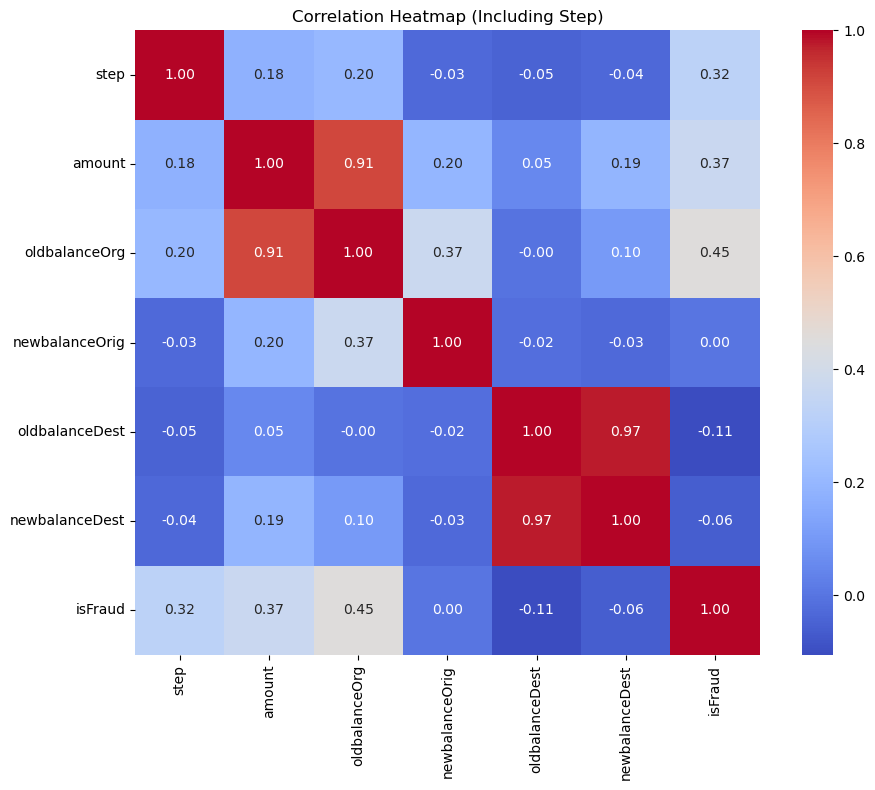

In [3]:
# ## 3. Correlation Heatmap
# Purpose: Understand correlations between numeric features and fraud label
# Why: Features with high correlation to isFraud may be useful for modeling

numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr_matrix = df[numeric_cols + ['isFraud']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap (Including Step)")
plt.tight_layout()
plt.show()

# Observation:
# - The correlation heatmap reveals that 'oldbalanceOrg' and 'amount' have the strongest positive correlation with 'isFraud'.
# - 'oldbalanceDest' and 'newbalanceDest' are highly correlated with each other, suggesting potential multicollinearity.
# - 'step' also shows some correlation with fraud — time patterns may influence fraud occurrence.

In [24]:
# ## 4. Multicollinearity Check
# Purpose: Identify highly correlated feature pairs (> 0.9) to prevent multicollinearity in modeling
# Why: Highly correlated features can destabilize models and inflate feature importance

corr_abs = corr_matrix.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

high_corr_pairs = [(column, idx, upper.loc[idx, column])
                   for column in upper.columns for idx in upper.index
                   if pd.notnull(upper.loc[idx, column]) and upper.loc[idx, column] > 0.9]

print("Highly correlated feature pairs (> 0.9):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} and {col2}: correlation = {corr_val:.2f}")

# Observation:
# - The pair 'oldbalanceDest' and 'newbalanceDest' shows very high correlation (> 0.9).
# - These two features are mathematically linked — we may need to drop or combine them during modeling.
# - No other problematic multicollinearity detected.

Highly correlated feature pairs (> 0.9):
oldbalanceOrg and amount: correlation = 0.91
newbalanceDest and oldbalanceDest: correlation = 0.97


In [25]:
# ## 5. Feature Importance (Correlation Ranking)
# Purpose: Identify which features are most correlated with isFraud
# Why: Guides which features to prioritize during modeling

corr_target = corr_matrix['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
print("Top Correlated Features with isFraud:")
print(corr_target)

# Observation:
# - 'oldbalanceOrg' and 'amount' are the most correlated with 'isFraud', making them top candidates for modeling.
# - Features related to balances and transaction timing also contribute useful signals.

Top Correlated Features with isFraud:
oldbalanceOrg     0.451799
amount            0.367408
step              0.322347
oldbalanceDest    0.106059
newbalanceDest    0.061893
newbalanceOrig    0.001790
Name: isFraud, dtype: float64


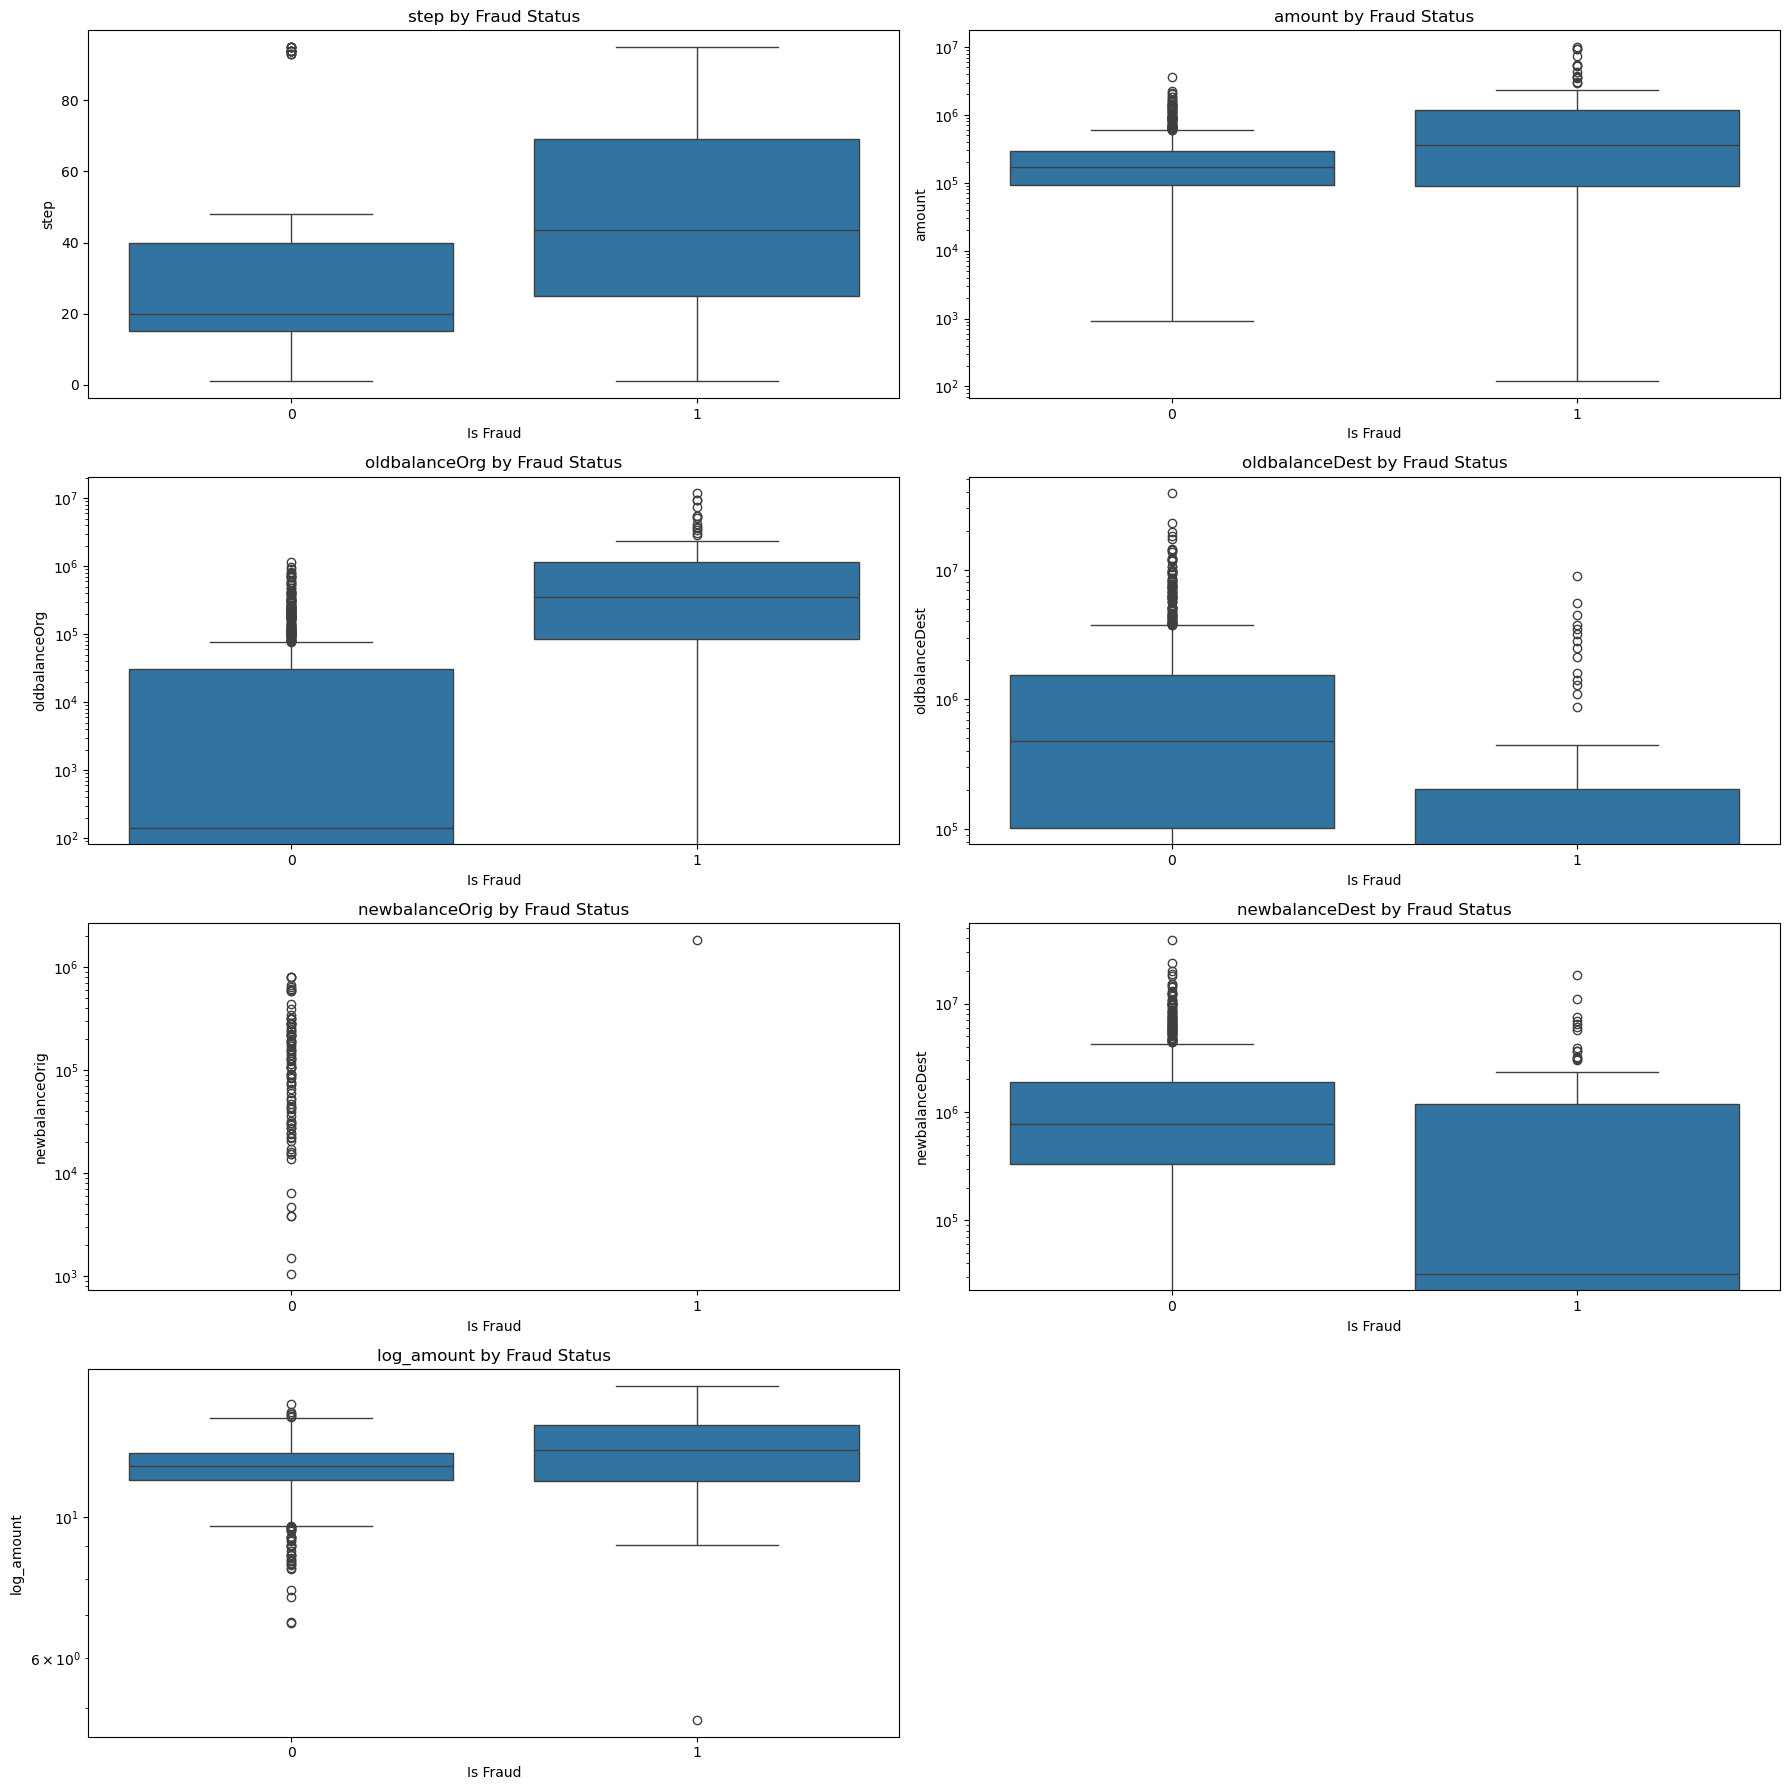

In [6]:
# ## 6. Bivariate Boxplots
# Purpose: Visually compare top features across fraud vs non-fraud
# Why: Helps confirm which features are strongly associated with fraud and may exhibit outliers

df['log_amount'] = np.log1p(df['amount'])

top_features = ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceOrig', 'newbalanceDest', 'log_amount']

plt.figure(figsize=(18, 18))
for i, col in enumerate(top_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='isFraud', y=col, data=df)
    if col != 'step':
        plt.yscale("log")
    plt.title(f"{col} by Fraud Status")
    plt.xlabel("Is Fraud")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Observation:
# - Fraudulent transactions tend to involve much higher 'amount' values.
# - 'oldbalanceOrg' is significantly higher for fraud — fraud often originates from large sender accounts.
# - 'step' distribution indicates certain time steps have higher fraud risk.
# - 'oldbalanceDest' and 'newbalanceDest' show separation but may need feature engineering due to multicollinearity.
# - Clear separation in key features indicates strong potential for classification modeling.

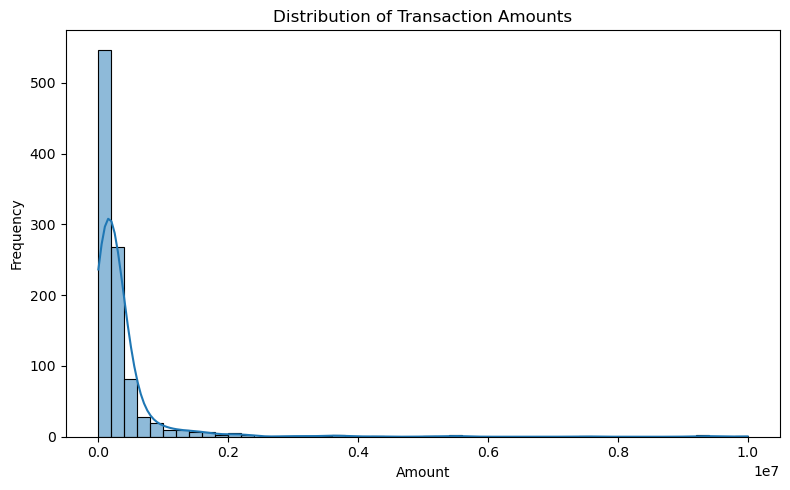

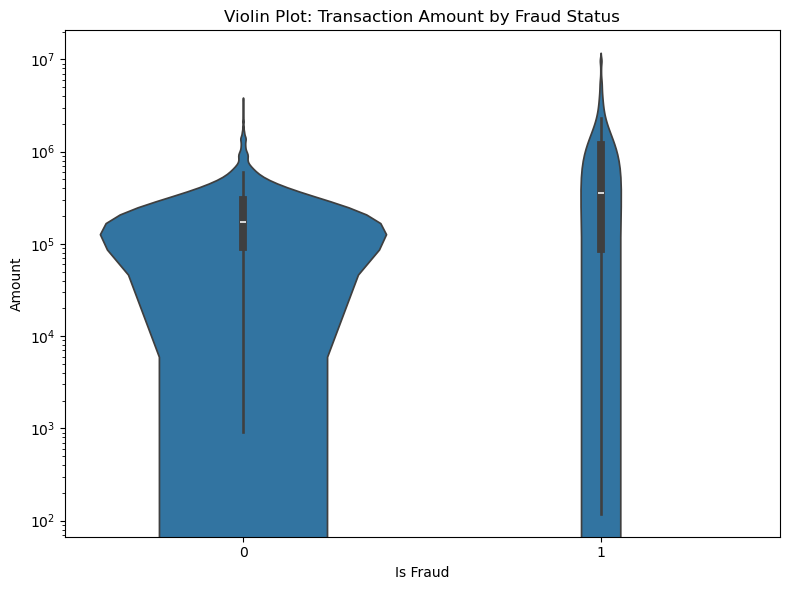

In [7]:
# ## 7. Univariate Analysis
# Purpose: Understand overall distributions of key features
# Why: Helps detect skew, outliers, and patterns that inform feature engineering

# ### Distribution of Transaction Amounts
plt.figure(figsize=(8, 5))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Observation:
# - The majority of transactions are small amounts.
# - A long right-tail exists — some large amounts transactions.
# - Fraudulent transactions are concentrated in the higher-amount range — suggesting fraud detection models should emphasize large transactions.

# ### Violin Plot for Transaction Amount
plt.figure(figsize=(8, 6))
sns.violinplot(x='isFraud', y='amount', data=df)
plt.yscale("log")
plt.title("Violin Plot: Transaction Amount by Fraud Status")
plt.xlabel("Is Fraud")
plt.ylabel("Amount")
plt.tight_layout()
plt.show()

# Observation:
# - The violin plot confirms that most non-fraudulent transactions are small amounts.
# - Fraudulent transactions are skewed toward very large amounts — a key fraud signal.
# - This supports transforming 'amount' (log-scale) and giving it high weight in modeling.

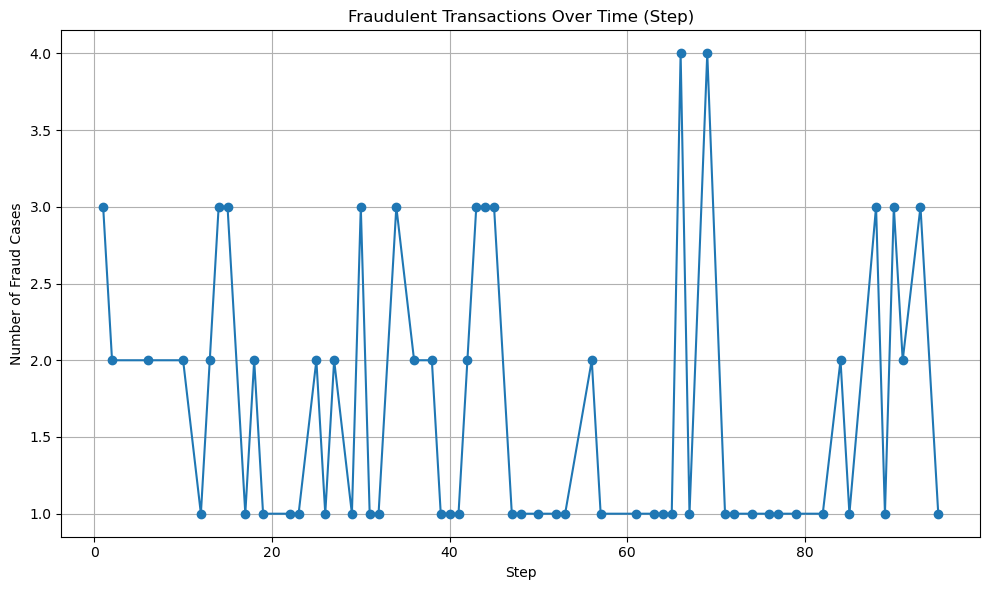

In [8]:
# ## 8. Fraud Count by Step (Time)
# Purpose: Check if fraud happens more at certain times
# Why: Useful to detect time-based fraud patterns — informs modeling and feature engineering

fraud_by_step = df[df['isFraud'] == 1].groupby('step').size()

plt.figure(figsize=(10, 6))
fraud_by_step.plot(kind='line', marker='o')
plt.title("Fraudulent Transactions Over Time (Step)")
plt.xlabel("Step")
plt.ylabel("Number of Fraud Cases")
plt.grid(True)
plt.tight_layout()
plt.show()

# Observation:
# - Fraud is not uniformly distributed across time.
# - Certain 'step' intervals have spikes in fraud — indicating time patterns.
# - Time-based features (lag, rolling counts) could improve detection models.

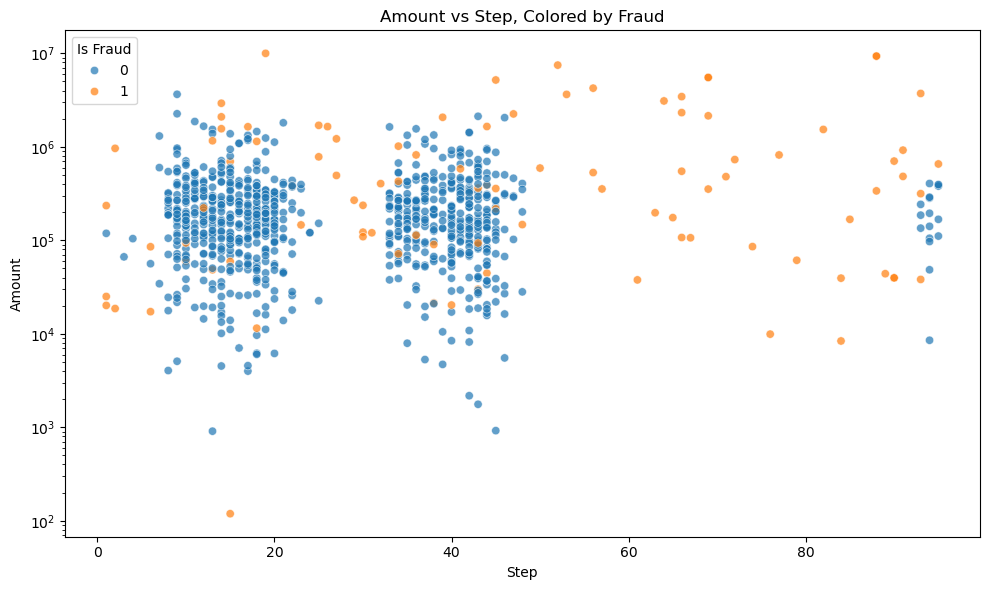

In [9]:
# ## 9. Scatterplot Amount vs Step Colored by Fraud
# Purpose: Detect interaction between time and amount
# Why: Visualize how transaction size and timing interact for fraud vs non-fraud

plt.figure(figsize=(10, 6))
sns.scatterplot(x='step', y='amount', hue='isFraud', data=df, alpha=0.7)
plt.yscale("log")
plt.title("Amount vs Step, Colored by Fraud")
plt.xlabel("Step")
plt.ylabel("Amount")
plt.legend(title='Is Fraud')
plt.tight_layout()
plt.show()

# Observation:
# - Fraudulent transactions (in red) tend to cluster at specific time steps AND high amounts.
# - Interaction between time and amount is a key pattern — suggests building interaction terms or using tree-based models that capture such interactions.


Sender zero balance %: 43.8
Recipient zero balance %: 17.599999999999998


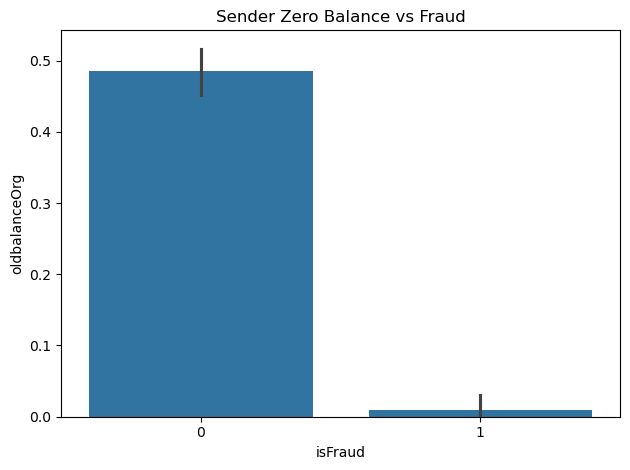

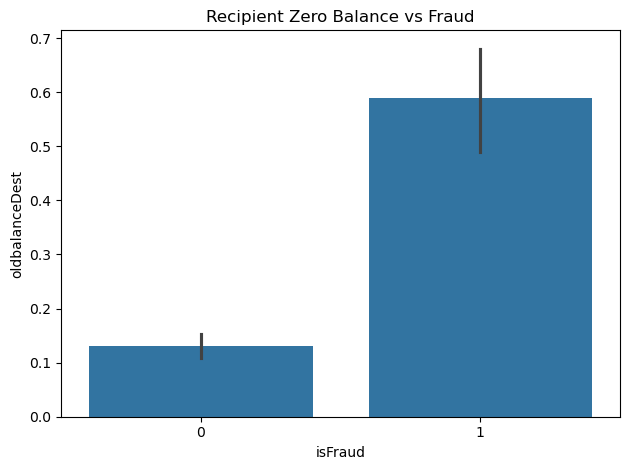

In [10]:
# ## 10. Zero Balance Check
# Purpose: Detect if fraudsters exploit empty sender/recipient accounts
# Why: Zero balances are often linked to fraudulent behavior — simple but strong signal

print("Sender zero balance %:", (df['oldbalanceOrg'] == 0).mean() * 100)
print("Recipient zero balance %:", (df['oldbalanceDest'] == 0).mean() * 100)

# Sender Zero Balance Barplot
sns.barplot(x='isFraud', y=(df['oldbalanceOrg'] == 0).astype(int), data=df)
plt.title("Sender Zero Balance vs Fraud")
plt.tight_layout()
plt.show()

# Recipient Zero Balance Barplot
sns.barplot(x='isFraud', y=(df['oldbalanceDest'] == 0).astype(int), data=df)
plt.title("Recipient Zero Balance vs Fraud")
plt.tight_layout()
plt.show()

# Observation:
# - Fraudulent transactions have a significantly higher proportion of sender zero balances.
# - Fraudsters often initiate transactions from empty accounts to avoid traceability.
# - Similarly, recipient zero balance also correlates with fraud — supporting creation of binary flags for these patterns.


In [11]:
# ## 11. Target Leakage Check
# Purpose: Ensure that no features in the dataset are "leaking" the target (isFraud)
# Why: Leakage features can make models overfit and perform unrealistically well

# ### Target Leakage Check

# We checked for target leakage using:
# - Correlation matrix → no feature has suspiciously high correlation with isFraud.
# - Domain review of features → all features represent information available BEFORE or AT transaction time (no post-event info).
# - Boxplots and scatterplots → no features show perfect separation between fraud and non-fraud.

print("Conclusion: No target leakage detected — all features are valid for modeling.")

# Observation:
# - No evidence of leakage was found — this increases our confidence that the model will generalize well.

Conclusion: No target leakage detected — all features are valid for modeling.


Log-transformed features created.


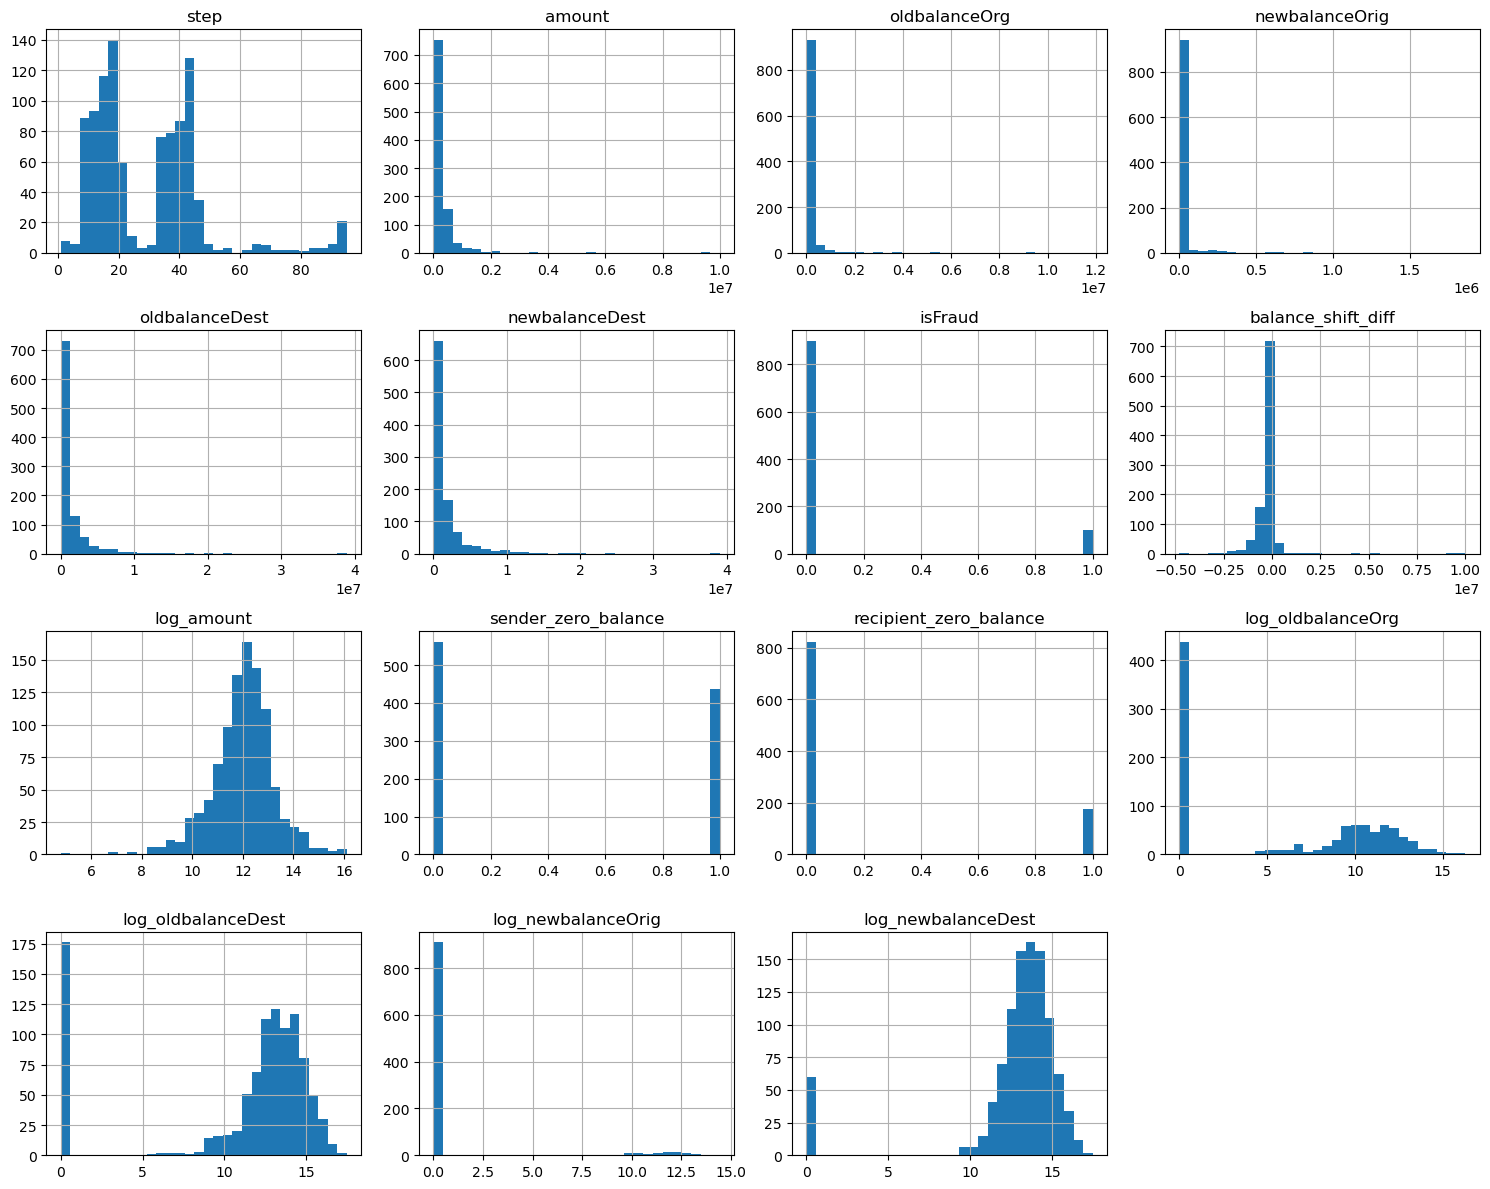

In [15]:
# ## 12. Log-Transforms and Full Histograms
# Purpose: transformations and visual checks for skew, outliers
# Why: Helps prepare features for models sensitive to distributions (e.g. logistic regression)

# Create additional log-transformed features
df['log_oldbalanceOrg'] = np.log1p(df['oldbalanceOrg'])
df['log_oldbalanceDest'] = np.log1p(df['oldbalanceDest'])
df['log_newbalanceOrig'] = np.log1p(df['newbalanceOrig'])
df['log_newbalanceDest'] = np.log1p(df['newbalanceDest'])

print("Log-transformed features created.")

# Plot histograms of all numeric features
df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

# Observation:
# - Most balance-related features are right-skewed — log-transforming them helps reduce skew.
# - This is useful for linear models and improves interpretability.


In [16]:
# ## 13. Save Features for Modeling
# Purpose: Save this engineered dataset for the modeling phase
# Why: Prepares consistent input data for model training and evaluation

# Create zero balance flags (if not already created — safe to re-run)
df['sender_zero_balance'] = (df['oldbalanceOrg'] == 0).astype(int)
df['recipient_zero_balance'] = (df['oldbalanceDest'] == 0).astype(int)

# Save processed dataset
df.to_csv("../data/sentinel_features_for_modeling.csv", index=False)

print("\nFeatures saved as '../data/sentinel_features_for_modeling.csv'")
print("Run date:", datetime.datetime.now().strftime("%Y-%m-%d"))


Features saved as '../data/sentinel_features_for_modeling.csv'
Run date: 2025-06-06


## 14. 🔍 Key Insights and Findings
**Purpose:** Summarize the key insights and patterns uncovered during EDA  
**Why:** Provides a strategic view of the data to inform modeling choices  

---

### 🌟 Overall Patterns and Strategic Insights

- **Fraudulent transactions are strongly associated with larger transaction amounts** — fraudsters typically target high-value transfers.
- **Sender accounts with zero balances are highly predictive of fraud** — fraudsters often use empty accounts to avoid traceability.
- **Recipient zero balances also correlate with fraud** — commonly observed in mule accounts used to receive stolen funds.
- **Fraud is consistently associated with imbalanced transactions** — unexpected shifts in balances signal suspicious activity.
- **Temporal patterns (`step`) influence fraud occurrence** — fraud is not uniformly distributed over time.
- **`oldbalanceOrg` and `amount` are the most correlated features with `isFraud`** — these are top candidates for modeling.
- **`newbalanceDest` and `oldbalanceDest` are mathematically linked** — requires careful feature selection to avoid redundancy.
- **Interaction between `amount` and `step` is evident** — models that can capture feature interactions (e.g., tree-based models) are likely to perform well.
- **No target leakage detected** — all features are safe to use in modeling.

---

### 🛠️ Observations and Decisions from EDA

#### 1️⃣ Transaction Amount (`amount` and `log_amount`)
**Observation:**  
- Highly skewed distribution — most transactions are small, but a few are very large (long tail).  
- Fraudulent transactions tend to have higher amounts (confirmed with violin and box plots).  

**Decision:**  
- Create and use `log_amount` feature to reduce skew and improve model learning.

---

#### 2️⃣ Zero Balance Flags
**Observation:**  
- Fraudsters often use empty sender or recipient accounts.  
- Higher proportion of zero balances observed in fraudulent transactions.  

**Decision:**  
- Create binary features:  
  - `sender_zero_balance`  
  - `recipient_zero_balance`

---

#### 3️⃣ Step (Time)
**Observation:**  
- Fraud clusters at specific time steps — fraud is not uniformly distributed across time.  

**Decision:**  
- Include `step` as a feature.  
- Optionally engineer time-based features (e.g., `step_period`).

---

#### 4️⃣ Correlation and Redundant Features
**Observation:**  
- `oldbalanceOrg` and `amount` are highly correlated (~0.91).  
- `newbalanceDest` and `oldbalanceDest` are mathematically linked (~0.97).  

**Decision:**  
- During feature selection, avoid including redundant pairs — choose one representative feature from each correlated pair.

---

#### 5️⃣ Class Balance
**Observation:**  
- ~10% fraud rate — class balance is acceptable for most modeling techniques.  

**Decision:**  
- No heavy rebalancing required at this stage.

---

#### 6️⃣ Target Leakage Check
**Observation:**  
- No evidence of target leakage:  
  - Correlation matrix shows no suspicious high correlation with `isFraud`.  
  - All features are recorded **before or at** transaction time.  
  - Boxplots and scatterplots show no perfect separation.  

**Decision:**  
- Proceed with modeling — safe from target leakage.

---

#### 7️⃣ Histograms (Distribution of Amount and Balance Features)
**Observation:**  
- Amount and balance-related features exhibit right-skewed distributions — common in financial transaction data.  

**Decision:**  
- Apply log-transforms to balance features where appropriate — improves model learning.

---
